# GAM Pyro Examples

In [399]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [400]:
import pandas as pd
import numpy as np
from orbit.models.tkr import TKRFull
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_iclaims, load_electricity_demand

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [401]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [402]:
df = load_electricity_demand()
m = df['electricity'].mean()
df['electricity'] = df['electricity']/m
df['electricity'] = np.log(df['electricity'])
df['tp'] = np.arange(0, len(df))/len(df)
# df, fs_cols = make_fourier_series_df(df, 'date', 365.25, order=10)
df

,date,electricity,tp
0,2000-01-01,-0.32819,0.00000
1,2000-01-02,-0.26449,0.00030
2,2000-01-03,-0.13014,0.00061
3,2000-01-04,-0.11187,0.00091
4,2000-01-05,-0.10490,0.00122
...,...,...,...
3283,2008-12-27,0.25753,0.99848
3284,2008-12-28,0.16131,0.99878
3285,2008-12-29,0.28150,0.99909
3286,2008-12-30,0.29870,0.99939


### Train / Test Split

In [403]:
test_size=365
train_df=df[:-test_size]
test_df=df[-test_size:]

## VI Fit and Predict - Fully Bayesian

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [422]:
tkr = TKRFull(
    response_col='electricity',
    date_col='date',
#     regressor_col=['tp'],
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 3],
#     regressor_col=fs_cols + ['trend.unemploy', 'trend.filling', 'trend.job'],
#     regressor_col=fs_cols + ['tp'] + ['trend.unemploy', 'trend.filling', 'trend.job'],
#     regressor_sign=['='] * 7,
    
#     level_knot_scale = 10,
#     regressor_knot_loc=[0] * 7,
#     regressor_knot_scale=[10] * 4,
#     positive_regressor_knot_pooling_scale=0.1,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.2,
    rho_coefficients=0.2,

    degree_of_freedom=30,
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    learning_rate_total_decay=1.0,
    verbose=True,
    message=100,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
)

In [423]:
%%time
tkr.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 37470, scale = 0.094523
step  100 loss = -3850.8, scale = 0.0095502
step  200 loss = -3785.5, scale = 0.011953
step  300 loss = -3821.6, scale = 0.014219
step  400 loss = -3951.6, scale = 0.015988
step  500 loss = -3982.8, scale = 0.016767
step  600 loss = -3921.2, scale = 0.017226
step  700 loss = -3659.8, scale = 0.019045
step  800 loss = -3961.8, scale = 0.018645
step  900 loss = -3857.4, scale = 0.018899
CPU times: user 8min 12s, sys: 17.9 s, total: 8min 30s
Wall time: 1min 15s


In [424]:
# data_input = gam_vi._get_model_data_input()
# data_input

In [425]:
# gam_vi._get_model_param_names()

In [426]:
predicted_df = tkr.predict(df=df, decompose=True)
predicted_df.head()

,date,seasonality_0_5,seasonality_0,seasonality_0_95,seasonality_1_5,seasonality_1,seasonality_1_95,trend_5,trend,trend_95,prediction_5,prediction,prediction_95
0,2000-01-01,-0.02268,-0.01058,0.00178,0.01167,0.02641,0.04064,-0.27879,-0.19308,-0.10919,-0.26208,-0.17725,-0.09059
1,2000-01-02,-0.05757,-0.04428,-0.03135,0.01239,0.02675,0.04072,-0.27700,-0.19011,-0.10809,-0.30193,-0.20693,-0.12109
2,2000-01-03,-0.03689,-0.02594,-0.01495,0.01311,0.02715,0.04105,-0.28190,-0.19360,-0.10524,-0.28311,-0.19052,-0.10927
3,2000-01-04,-0.01843,-0.00637,0.00603,0.01349,0.02771,0.04143,-0.27845,-0.19037,-0.10527,-0.25925,-0.16949,-0.08304
4,2000-01-05,-0.00432,0.00740,0.01901,0.01414,0.02822,0.04181,-0.28665,-0.19563,-0.10613,-0.25413,-0.15933,-0.06565


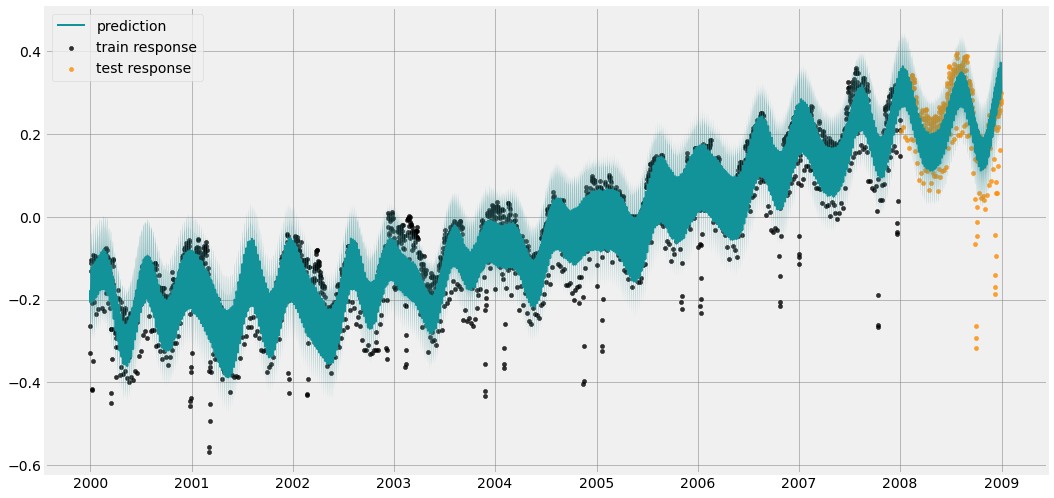

In [427]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='date', actual_col='electricity', 
                    test_actual_df=test_df)

In [428]:
def plot_predicted_components(predicted_df, date_col, prediction_percentiles=None, title="", figsize=None, path=None,
                             plot_components=None):
    """ Plot predicted componenets with the data frame of decomposed prediction where components
    has been pre-defined as `trend`, `seasonality` and `regression`.
    Parameters
    ----------
    predicted_df: pd.DataFrame
        predicted data response data frame. two columns required: actual_col and pred_col. If
        user provide pred_percentiles_col, it needs to include them as well.
    date_col: str
        the date column name
    prediction_percentiles: list
        a list should consist exact two elements which will be used to plot as lower and upper bound of
        confidence interval
    title: str
        title of the plot
    figsize: tuple
        figsize pass through to `matplotlib.pyplot.figure()`
    path: str
        path to save the figure
   Returns
    -------
        None
    """

    _predicted_df=predicted_df.copy()
    _predicted_df[date_col] = pd.to_datetime(_predicted_df[date_col])
    if plot_components is None:
        plot_components = [PredictedComponents.TREND.value,
                           PredictedComponents.SEASONALITY.value,
                           PredictedComponents.REGRESSION.value]

    plot_components = [p for p in plot_components if p in _predicted_df.columns.tolist()]
    n_panels = len(plot_components)
    if not figsize:
        figsize=(16, 8)

    if prediction_percentiles is None:
        _pred_percentiles = [5, 95]
    else:
        _pred_percentiles = prediction_percentiles

    if len(_pred_percentiles) != 2:
        raise ValueError("prediction_percentiles has to be None or a list with length=2.")

    fig, axes = plt.subplots(n_panels, 1, facecolor='w', figsize=figsize)
    for ax, comp in zip(axes, plot_components):
        y = predicted_df[comp].values
        ax.plot(_predicted_df[date_col], y, marker=None, color='#12939A')
        confid_cols = ["{}_{}".format(comp, _pred_percentiles[0]), "{}_{}".format(comp, _pred_percentiles[1])]
        if set(confid_cols).issubset(predicted_df.columns):
            ax.fill_between(_predicted_df[date_col].values,
                            _predicted_df[confid_cols[0]],
                            _predicted_df[confid_cols[1]],
                            facecolor='#42999E', alpha=0.5)
        ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.5)
        ax.set_title(comp, fontsize=16)
    plt.suptitle(title, fontsize=16)
    fig.tight_layout()

    if path:
        plt.savefig(path)

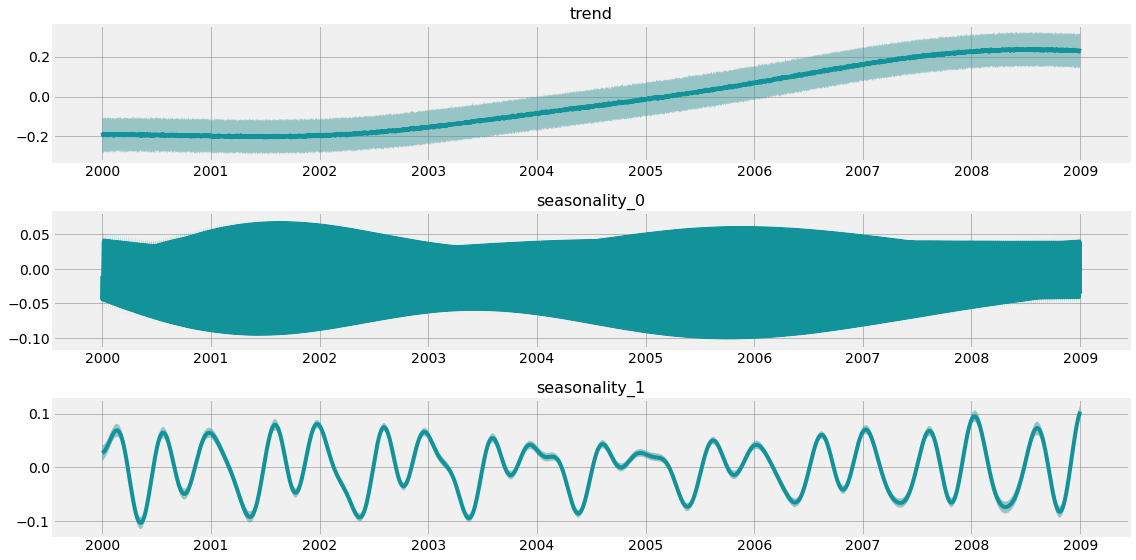

In [429]:
plot_predicted_components(predicted_df, 'date', plot_components=['trend','seasonality_0','seasonality_1','regression'])

In [435]:
df = load_iclaims()
m = df['claims'].mean()
df['claims'] = df['claims']/m
df['claims'] = np.log(df['claims'])
df

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.68686,1.18397,0.72014,1.11967
1,2010-01-10,0.92449,1.18397,0.81490,1.17860
2,2010-01-17,0.69901,1.20338,0.73909,1.11967
3,2010-01-24,0.43782,1.16456,0.81490,1.10788
4,2010-01-31,0.49703,1.08693,0.77699,1.07253
...,...,...,...,...,...
438,2018-05-27,-0.47953,1.06752,0.98546,1.04895
439,2018-06-03,-0.53697,1.08693,1.00441,1.04895
440,2018-06-10,-0.41075,1.08693,1.09916,1.06074
441,2018-06-17,-0.46399,1.04811,1.09916,1.02538


In [443]:
tkr = TKRFull(
    response_col='claims',
    date_col='week',
#     regressor_col=['tp'],
    seasonality=365.25/7,
    seasonality_fs_order=[8],
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.2,
    rho_coefficients=0.2,

    degree_of_freedom=30,
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    learning_rate_total_decay=1.0,
    verbose=True,
    message=100,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
)

In [444]:
tkr._regressor_col

['layer0_fs_cos1',
 'layer0_fs_sin1',
 'layer0_fs_cos2',
 'layer0_fs_sin2',
 'layer0_fs_cos3',
 'layer0_fs_sin3',
 'layer0_fs_cos4',
 'layer0_fs_sin4',
 'layer0_fs_cos5',
 'layer0_fs_sin5',
 'layer0_fs_cos6',
 'layer0_fs_sin6',
 'layer0_fs_cos7',
 'layer0_fs_sin7',
 'layer0_fs_cos8',
 'layer0_fs_sin8']

In [445]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [446]:
%%time
tkr.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 1610.4, scale = 0.10842
step  100 loss = -44.665, scale = 0.061055
step  200 loss = -72.093, scale = 0.080259
step  300 loss = -77.968, scale = 0.089742
step  400 loss = -80.028, scale = 0.1018
step  500 loss = -71.245, scale = 0.10991
step  600 loss = -81.896, scale = 0.11491
step  700 loss = -82.498, scale = 0.12118
step  800 loss = -76.518, scale = 0.12697
step  900 loss = -69.274, scale = 0.13023
CPU times: user 1min 42s, sys: 1.77 s, total: 1min 44s
Wall time: 15.2 s


In [447]:
predicted_df = tkr.predict(df=df, decompose=True)
predicted_df.head()

,week,seasonality_0_5,seasonality_0,seasonality_0_95,trend_5,trend,trend_95,prediction_5,prediction,prediction_95
0,2010-01-03,0.27496,0.36546,0.46199,0.41063,0.55550,0.71163,0.74791,0.91707,1.10611
1,2010-01-10,0.16918,0.25993,0.34571,0.39085,0.54882,0.70433,0.63517,0.81018,0.99377
2,2010-01-17,0.03969,0.12893,0.21580,0.38985,0.54541,0.69716,0.50166,0.67252,0.84393
3,2010-01-24,-0.08284,0.00861,0.09322,0.38132,0.53375,0.67912,0.36116,0.54269,0.70983
4,2010-01-31,-0.15644,-0.06754,0.01645,0.37735,0.52489,0.68047,0.28888,0.45740,0.62141


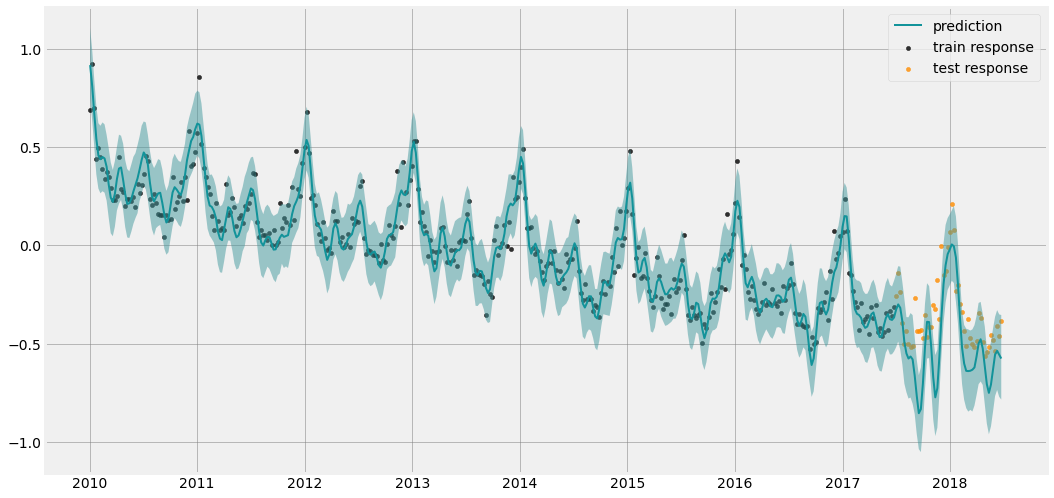

In [448]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

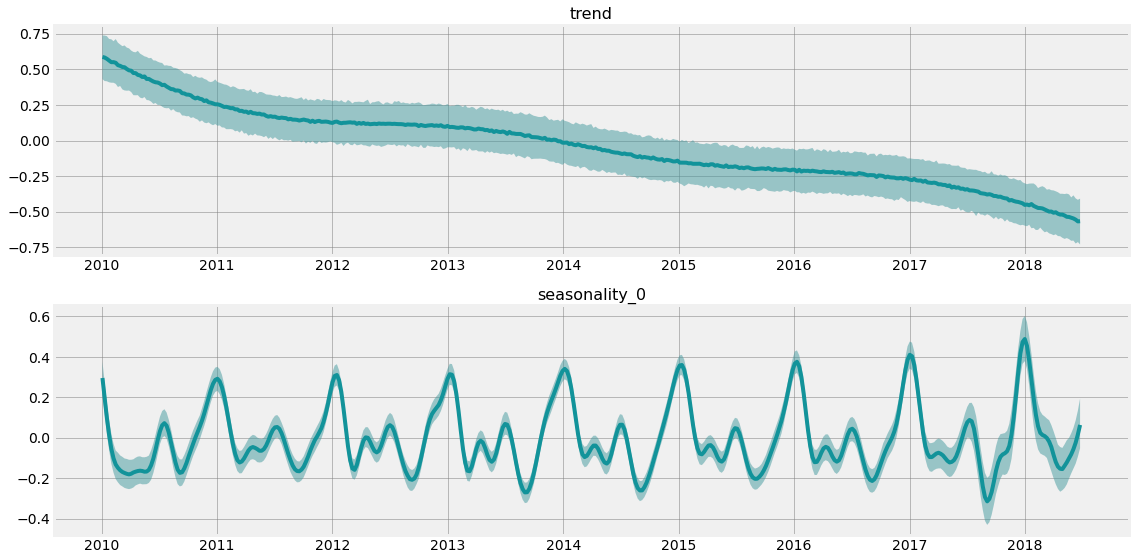

In [442]:
plot_predicted_components(predicted_df, 'week', plot_components=['trend','seasonality_0'])